In [1]:
#..................import library and module...........................
import tensorflow as tf

from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Lambda, BatchNormalization,LSTM,TimeDistributed,Activation,Dense)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os 

  
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import random

Using TensorFlow backend.


In [2]:
#tf.random.set_seed(42)

In [3]:
def reset_random_seeds():
    seed_num=9
    os.environ['PYTHONHASHSEED']=str(seed_num)
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
   

In [4]:
#.........................data preprocessing.........................................

In [5]:
def get_labels():
    labels =["আমি এসএসএল ওয়ারলেসে জব",
            "আমি ডাটা টিমের সদস্য",
            "আমাদের ডেটা টিমে দুইজন জমজ ভাই আছে"] 
    #labels=os.listdir(path)
    print(len(labels))
    label_indices = np.arange(0, len(labels))
    print(label_indices)
    return labels, label_indices

In [6]:
#data_path="E:/speech_recognition/data/"
labels,label_indices=get_labels()
print(labels)

3
[0 1 2]
['আমি এসএসএল ওয়ারলেসে জব', 'আমি ডাটা টিমের সদস্য', 'আমাদের ডেটা টিমে দুইজন জমজ ভাই আছে']


In [7]:
# Mel-frequency cepstral coefficients
def wav2mfcc(file_path,max_len, n_mfcc):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=n_mfcc) #sr=16000, n_mfcc=
    print(mfcc.shape[0],mfcc.shape[1])
    
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc,wave

In [8]:
def save_data_to_array(path, max_len, n_mfcc):
    #labels,_, _ = get_labels()

    #for label in labels:
        # Init mfcc vectors
    mfcc_vectors = []
   
    audio=[]
    for wav in path:
        wavfile=f'E:/speech_recognition/data/{wav}'
        print(wavfile)
        audio.append(wavfile)
        mfcc,wave= wav2mfcc(wavfile, max_len, n_mfcc)
        mfcc_vectors.append(mfcc)
    np.save('E:/speech_recognition/wav', mfcc_vectors)
    return mfcc_vectors,wave,audio

In [9]:
root_dir=os.listdir("E:/speech_recognition/data/")
mfcc_vec,wave,audio=save_data_to_array(root_dir,114,34)
print(mfcc_vec[0].shape)
#print(mfcc_vec)

E:/speech_recognition/data/audio_1.wav
34 67
E:/speech_recognition/data/audio_2.wav
34 83
E:/speech_recognition/data/audio_3.wav
34 114
(34, 114)


In [10]:
#..............................check  audio ................
print(audio)
ipd.Audio(audio[0])

['E:/speech_recognition/data/audio_1.wav', 'E:/speech_recognition/data/audio_2.wav', 'E:/speech_recognition/data/audio_3.wav']


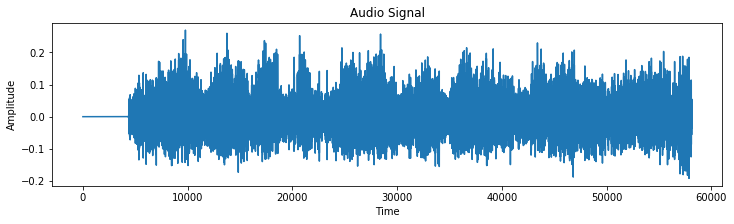

In [11]:
#.............plot raw audio...........................
def plot_raw_audio(vis_raw_audio):
    # plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
plot_raw_audio(wave)

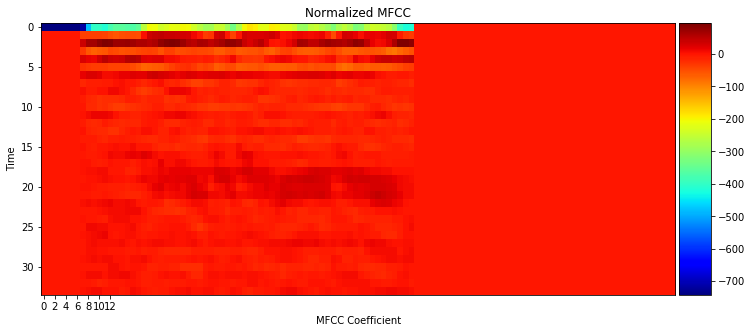

In [12]:
#....................plot mfcc_vec.........................
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    
plot_mfcc_feature(mfcc_vec[0])

In [13]:
mfcc_vec[0]

array([[-741.61414, -741.61414, -741.61414, ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [14]:
labels=labels
print(labels)

['আমি এসএসএল ওয়ারলেসে জব', 'আমি ডাটা টিমের সদস্য', 'আমাদের ডেটা টিমে দুইজন জমজ ভাই আছে']


In [15]:
char_map_str = """
ঀ 0
ঁ 1
ং 2
ঃ 3
অ 4
আ 5
ই 6
ঈ 7
উ 8
ঊ 9
ঋ 10
ঌ 11
এ 12
ঐ 13
ও 14
ঔ 15
ক 16
খ 17
গ 18
ঘ 19
ঙ 20
চ 21
ছ 22
জ 23
ঝ 24
ঞ 25
ট 26
ঠ 27
ড 28
ঢ 29
ণ 30
ত 31
থ 32
দ 33
ধ 34
ন 35
প 36
ফ 37
ব 38
ভ 39
ম 40
য 41
র 42
ল 43
শ 44
ষ 45
স 46
হ 47
় 48
ঽ 49
া 50
ি 51
ী 52
ু 53
ূ 54
ৃ 55
ৄ 56
ে 57
ৈ 58
ো 59
ৌ 60
্ 61
ৎ 62
ৗ 63
ড় 64
ঢ় 65
য় 66
ৠ 67
০ 68
১ 69
২ 70
৩ 71
৪ 72
৫ 73
৬ 74
৭ 75
৮ 76
৯ 77
ৱ 78
৲ 79
৴ 80
<SPACE> 81
"""
# the "blank" character is mapped to 84
char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
index_map[81] = ' '

In [16]:
print(char_map)
print("****************************************************")
print(index_map)

{'ঀ': 0, 'ঁ': 1, 'ং': 2, 'ঃ': 3, 'অ': 4, 'আ': 5, 'ই': 6, 'ঈ': 7, 'উ': 8, 'ঊ': 9, 'ঋ': 10, 'ঌ': 11, 'এ': 12, 'ঐ': 13, 'ও': 14, 'ঔ': 15, 'ক': 16, 'খ': 17, 'গ': 18, 'ঘ': 19, 'ঙ': 20, 'চ': 21, 'ছ': 22, 'জ': 23, 'ঝ': 24, 'ঞ': 25, 'ট': 26, 'ঠ': 27, 'ড': 28, 'ঢ': 29, 'ণ': 30, 'ত': 31, 'থ': 32, 'দ': 33, 'ধ': 34, 'ন': 35, 'প': 36, 'ফ': 37, 'ব': 38, 'ভ': 39, 'ম': 40, 'য': 41, 'র': 42, 'ল': 43, 'শ': 44, 'ষ': 45, 'স': 46, 'হ': 47, '়': 48, 'ঽ': 49, 'া': 50, 'ি': 51, 'ী': 52, 'ু': 53, 'ূ': 54, 'ৃ': 55, 'ৄ': 56, 'ে': 57, 'ৈ': 58, 'ো': 59, 'ৌ': 60, '্': 61, 'ৎ': 62, 'ৗ': 63, 'ড়': 64, 'ঢ়': 65, 'য়': 66, 'ৠ': 67, '০': 68, '১': 69, '২': 70, '৩': 71, '৪': 72, '৫': 73, '৬': 74, '৭': 75, '৮': 76, '৯': 77, 'ৱ': 78, '৲': 79, '৴': 80, '<SPACE>': 81}
****************************************************
{0: 'ঀ', 1: 'ঁ', 2: 'ং', 3: 'ঃ', 4: 'অ', 5: 'আ', 6: 'ই', 7: 'ঈ', 8: 'উ', 9: 'ঊ', 10: 'ঋ', 11: 'ঌ', 12: 'এ', 13: 'ঐ', 14: 'ও', 15: 'ঔ', 16: 'ক', 17: 'খ', 18: 'গ', 19: 'ঘ', 20: 'ঙ', 21: 'চ', 22: 'ছ', 23: 'জ', 24: '

In [17]:
def get_number_of_char_classes(char_map):
    ## TODO would be better to check with dataset (once cleaned)
    num_classes = len(char_map)+1 #need +1 for ctc null char +1 pad
    return num_classes
get_number_of_char_classes(char_map)

83

In [18]:
def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

In [19]:
data={"mfcc":mfcc_vec,
      "utterance":labels}
final_df=pd.DataFrame(data,columns=['mfcc',"utterance"])
final_df

,mfcc,utterance
0,"[[-741.61414, -741.61414, -741.61414, -741.614...",আমি এসএসএল ওয়ারলেসে জব
1,"[[-761.2525, -761.2525, -761.2525, -761.2525, ...",আমি ডাটা টিমের সদস্য
2,"[[-751.19977, -751.19977, -751.19977, -751.199...",আমাদের ডেটা টিমে দুইজন জমজ ভাই আছে


In [20]:
final_df.shape

(3, 2)

In [21]:
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

def normalize_feature(feature, eps=1e-14):
         
        #feat_dim = calc_feat_dim(34,8000)
        #feats_mean = np.zeros((feat_dim,))
        #feats_std = np.ones((feat_dim,))
        
        feats = np.vstack(feature)
        feats_mean = np.mean(feats, axis=0)
        feats_std = np.std(feats, axis=0)
        
        return (feature - feats_mean) / (feats_std + eps)

In [22]:
from past.builtins import xrange

def map_input_data(final_df):
    
    max_length = max([x.shape[0] for x in final_df['mfcc']])
    max_string_length = max([len(x) for x in final_df['utterance']])
    #print(max_string_length)
    X_data = np.zeros([final_df.shape[0], max_length,114]) #here 114 means input shape
    #print(X_data)
    labels = np.ones([final_df.shape[0], max_string_length])*81
    input_length = np.zeros([final_df.shape[0], 1])
    label_length = np.zeros([final_df.shape[0], 1])
    #print(len(label_length))
    for i in range(0, final_df.shape[0]):
        feat = final_df.iloc[i]['mfcc']
        input_length[i] = feat.shape[0]
        #print(input_length)
        X_data[i, :feat.shape[0], :] = feat
        #print(X_data[i, :feat.shape[0], :])
        #print(len(final_df.iloc[i]['utterance']))
        # calculate labels & label_length
        #label = np.array(final_df.iloc[i]['utterance'])
        y=final_df.iloc[i]['utterance']
        #y=[' '.join(y[i:i+19]) for i in xrange(0,len(y),19)]                                                  
        print(y)
        label=np.array(text_to_int_sequence(y))
        print((label))
        print(len(label))
        labels[i, :len(label)] = label
        #if feat.shape[0]<=len(label):
            #print(feat.shape[0])
            #label_length[i]=[' '.join(str(label[i:i+19])) for i in range(0,len(label),19)] 
        label_length[i] = len(label)

    #print(X_data)
    X_data=normalize_feature(X_data,eps=1e-14)
    # return the arrays
    outputs = {'ctc': np.zeros([final_df.shape[0]])}
    #outputs = {'ctc': np.zeros(20)}
    outputs_1 = {'ctc': np.zeros([final_df.shape[0]])[2:3]}
    #outputs={'labels': np.asarray(labels),
             #'label_length':np.asarray(label_length)}
        
    inputs = {'input': X_data,   
              'labels': labels,
              'input_length':input_length ,
              'label_length':label_length
              }
    inputs_1 = {'input': X_data[2:3],   
              'labels': labels[2:3],
                 'input_length':input_length[2:3] ,
                  'label_length':label_length[2:3]
              }
    
    #return (inputs,outputs),(inputs_1,outputs_1),X_data,labels,input_length,label_length
    return (inputs,outputs) 

In [23]:
#np.zeros([3, 1])

In [24]:
#(input_dict,outputs),(inputs_1,outputs_1),X_data,labels,input_length,label_length=map_input_data(final_df)
(input_dict,outputs)=map_input_data(final_df)


আমি এসএসএল ওয়ারলেসে জব
[ 5 40 51 81 12 46 12 46 12 43 81 14 66 50 42 43 57 46 57 81 23 38]
22
আমি ডাটা টিমের সদস্য
[ 5 40 51 81 28 50 26 50 81 26 51 40 57 42 81 46 33 46 61 41]
20
আমাদের ডেটা টিমে দুইজন জমজ ভাই আছে
[ 5 40 50 33 57 42 81 28 57 26 50 81 26 51 40 57 81 33 53  6 23 35 81 23
 40 23 81 39 50  6 81  5 22 57]
34


In [25]:
print(input_dict)#print(inputs_1)

{'input': array([[[-5.66749492, -5.66749492, -5.66749492, ...,  0.13223565,
          0.11878887,  0.09290018],
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018],
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018],
        ...,
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018],
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018],
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018]],

       [[-5.82218284, -5.82218284, -5.82218284, ...,  0.13223565,
          0.11878887,  0.09290018],
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018],
        [ 0.17406744,  0.17406744,  0.17406744, ...,  0.13223565,
          0.11878887,  0.09290018],
        ...,
        [ 0.17406744,  0.17406744,  0.174067

In [26]:
print(outputs)#print(outputs_1)

{'ctc': array([0., 0., 0.])}


In [27]:
#list(input_dict.values())[0][0]

In [28]:
print(outputs)

{'ctc': array([0., 0., 0.])}


In [29]:
def ctc_lambda_func(args):
    #import tensorflow as tf
    
    y_pred, labels, input_length, label_length = args
    #y_pred = y_pred[:, 2:, :]
    #print(y_pred.shape)
    #print(input_length)
    #print(labels.shape)
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    #return tf.compat.v1.nn.ctc_loss(labels, y_pred, input_length,label_length,
                                    #ignore_longer_outputs_than_inputs=True)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    print(output_lengths)
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths,label_lengths],
        outputs=loss_out)
    return model




 



In [30]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                      dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size ) * (dilation)
    border_mode="valid"
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

In [31]:
def ctc(y_true, y_pred):
    return y_pred

In [32]:
#.................................model_1.........................................
def deep_rnn_model(input_dim, output_dim=83):
    #output_dimension means num of classes
    units =200
    recur_layers = 25
    input_data = Input(name='input', shape=(None, input_dim))
    # TODO: Add recurrent layers, each with batch normalization
    if recur_layers == 1:
        layer = LSTM(units, return_sequences=True, activation='relu')(input_data)
        layer = BatchNormalization(name='bt_rnn_1')(layer)
    else:
        layer = LSTM(units, return_sequences=True, activation='relu')(input_data)
        layer = BatchNormalization(name='bt_rnn_1')(layer)

        for i in range(recur_layers - 2):
            layer = LSTM(units, return_sequences=True, activation='relu')(layer)
            layer = BatchNormalization(name='bt_rnn_{}'.format(2 + i))(layer)

        layer = LSTM(units, return_sequences=True, activation='relu')(layer)
        layer = BatchNormalization(name='bt_rnn_last_rnn')(layer)

    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(layer)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    #print(x)
    model.output_length= lambda x: x
    #print(model.output_length.shape)
    #model.output_length = lambda x:cnn_output_length(x,1,border_mode="valid",stride=2)
    #model.summary()
    #model=model.summary()
    return model

In [33]:
#.............................model-2...........................................
from keras.layers import Dense, Activation, Bidirectional, Reshape, Flatten, Lambda, Input,\
    Masking, Convolution1D, BatchNormalization, GRU, Conv1D, RepeatVector, Conv2D
from keras.optimizers import SGD, adam

def final_model_1(input_dim, filters,kernel_size,conv_stride,
                  conv_border_mode,output_dim,number_of_layers,units):
    """ Build a deep network for speech 
    """
    dropout_rate=0.5
    cell=GRU 
    activation='tanh'
    
    # Main acoustic input
    input_data = Input(name='input', shape=(None, input_dim))
    # TODO: Specify the layers in your network
    conv_1d = Conv1D(filters, kernel_size,
                     strides=conv_stride,
                     padding=conv_border_mode,
                     activation='relu',
                     name='layer_1_conv',
                     dilation_rate=1)(input_data)
    conv_bn = BatchNormalization(name='conv_batch_norm')(conv_1d)

    if number_of_layers == 1:
        layer = cell(units, activation=activation,
                     return_sequences=True, implementation=2, name='rnn_1', dropout=dropout_rate)(conv_bn)
        layer = BatchNormalization(name='bt_rnn_1')(layer)
    else:
        layer = cell(units, activation=activation,
                     return_sequences=True, implementation=2, name='rnn_1', dropout=dropout_rate)(conv_bn)
        layer = BatchNormalization(name='bt_rnn_1')(layer)

        for i in range(number_of_layers - 2):
            layer = cell(units, activation=activation,
                         return_sequences=True, implementation=2, name='rnn_{}'.format(i + 2), dropout=dropout_rate)(layer)
            layer = BatchNormalization(name='bt_rnn_{}'.format(i + 2))(layer)

        layer = cell(units, activation=activation,
                     return_sequences=True, implementation=2, name='final_layer_of_rnn')(layer)
        layer = BatchNormalization(name='bt_rnn_final')(layer)

    time_dense = TimeDistributed(Dense(output_dim))(layer)
    # TODO: Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    # TODO: Specify model.output_length
    model.output_length = lambda x:x
                           #cnn_output_length(x, kernel_size,conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [34]:
def next_train(train_data,minibatch_size):
    """ Obtain a batch of training data
    """
    cur_train_index=0
    while True:
        ret = train_data
        cur_train_index +=minibatch_size   
        yield ret    

def next_valid(valid_data,minibatch_size):
    """ Obtain a batch of validation data
    """
    cur_valid_index=0
    while True:
        ret =valid_data
        cur_valid_index +=minibatch_size
        yield ret


In [35]:

def train_model(X,Y,optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),epochs=20,verbose=1):
    import tensorflow as tf
    import math
    
    reset_random_seeds()
    #model_1 = deep_rnn_model(input_dim=114)
    model_1= final_model_1(input_dim=114,filters=200,kernel_size=1,conv_stride=1,
                                                    conv_border_mode='valid',
                                                    output_dim=83,
                                                    number_of_layers=2,
                                                    units=200)
    model=model_1
    model = add_ctc_loss(model)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    #model.compile(loss=ctc, optimizer=optimizer)
    #model.compile(loss=tf.compat.v1.nn.ctc_loss(the_labels=ctc,
                            #ignore_longer_outputs_than_inputs=True), optimizer=optimizer)
                                                    
    #if not os.path.exists('results'):
        #os.makedirs('results')
        #checkpointer = ModelCheckpoint(filepath='results/ASR_model.h5', verbose=0)
    #hist = model.fit(x=X,y=Y,batch_size=10,epochs=epochs,validation_split=0.25)
    #x=(X,Y)
    #x_1=(X_1,Y_1)
    #n_points =3
    #batch_size =10
    train_steps = math.ceil(3/10)
    valid_steps=math.ceil(1/10)
    
    checkpoint_path = "E:/Deep_speech_recognition/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    #hist = model.fit_generator(generator=next_train(x,10),
                              #steps_per_epoch=train_steps,
                              #epochs=20,
                              #validation_data=next_valid(x_1,10),
                               #validation_steps=valid_steps,
                               #callbacks=[cp_callback])
                                    
    hist = model.fit(x=X,y=Y,batch_size=10,epochs=200,validation_split=0.25,
                    callbacks=[cp_callback])                            
    return (hist,model,model_1)                     

In [36]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(input_dict,output, test_size=0.25, random_state=42)

In [37]:
hist,model,model_1=train_model(input_dict,outputs)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 114)         0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, None, 200)         23000     
_________________________________________________________________
conv_batch_norm (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
final_layer_of_rnn (GRU)     (None, None, 200)         240600    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 200)         800 

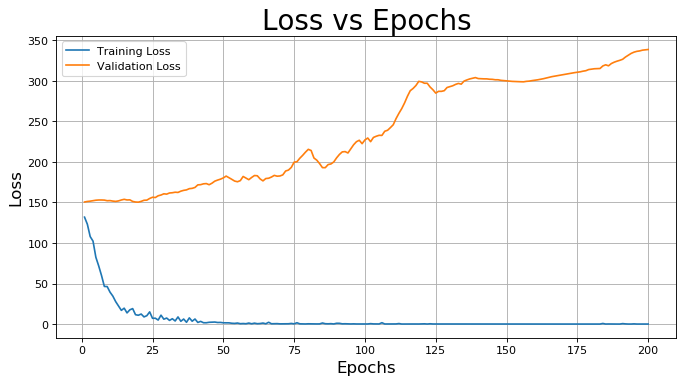

In [38]:
#plot the loss 
history_dict = hist.history
keys = history_dict.keys()
loss = history_dict['loss']
val_loss = history_dict['val_loss']
 
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

In [39]:
model_save=model.save("E:/Deep_speech_recognition/model.h5")
#new_model = tf.keras.models.load_model("E:/Deep_speech_recognition/model.h5")

In [40]:
from keras import backend as K

def get_predictions_1(model_final,data_point):
    
    #print(data_point.shape[0])    
    # obtain and decode the acoustic model's predictions
    #model_final=deep_rnn_model(input_dim=114)
    model_final.load_weights("E:/Deep_speech_recognition/model.h5")
    #model.load_weights("E:/Deep_speech_recognition/save_model/test_final.h5")
    data_point=normalize_feature(data_point, eps=1e-14)
    prediction = model_final.predict(np.expand_dims(data_point, axis=0))
    print(prediction.shape)
    print(prediction)
    #prediction = model()
    output_length = [model_final.output_length(data_point.shape[0])]
    print(output_length)
    
    pred_ints = (K.eval(K.ctc_decode(prediction,output_length)[0][0])).flatten().tolist()
    out=prediction
    #pred_ints = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                         #greedy=True)[0][0])
    print(pred_ints)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)
    


In [41]:
#mfcc_vec_1=[mfcc_vec[0]]
#mfcc_vec_1 = np.concatenate([arr[np.newaxis] for arr in mfcc_vec_1])
#print(mfcc_vec_1.shape)
#mfcc_vec_1=[mfcc_vec_1]
#mfcc_vec_1 = np.concatenate([arr[np.newaxis] for arr in mfcc_vec_1])
#print(mfcc_vec_1.shape)
#print(mfcc_vec_1)
#list(mfcc_vec[0].values())[0]

In [42]:
get_predictions_1(model_1,mfcc_vec[0])
#get_predictions_1(model,[np.expand_dims(mfcc_vec[0],axis=0),labels[0],input_length[0],label_length[0]])
 

(1, 34, 83)
[[[5.4987049e-07 3.7155378e-06 1.9152963e-06 ... 2.4366743e-06
   3.9843829e-07 1.5772222e-06]
  [5.3329813e-06 2.9278146e-06 2.0337516e-06 ... 1.6658370e-06
   8.1609190e-12 6.1709170e-06]
  [1.1461951e-05 1.1499857e-05 5.3609870e-06 ... 1.1719492e-05
   7.6969273e-12 3.4578079e-05]
  ...
  [2.7021313e-10 9.3884167e-10 1.3194580e-10 ... 3.9777248e-10
   9.9999499e-01 2.9947431e-10]
  [1.3194073e-05 9.2438822e-05 1.4604788e-05 ... 2.7246875e-05
   5.9783942e-01 2.5649584e-05]
  [2.6117614e-05 1.7580709e-04 4.8973568e-05 ... 7.2422154e-05
   1.5090215e-04 5.8495749e-05]]]
[34]
[5, 40, 51, 81, 12, 46, 12, 46, 26, 81, 14, 66, 50, 42, 43, 81, 46, 41, 81, 26]
--------------------------------------------------------------------------------
Predicted transcription:

আমি এসএসট ওয়ারল সয ট
--------------------------------------------------------------------------------
